**STEP 1 : Installing Libraries**

In [ ]:
!pip install xarray netCDF4 pandas numpy scikit-learn tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00


**Importing all libraries**

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Checking for the data in the .nc file
ds = xr.open_dataset("/content/era5_data/data_stream-oper_stepType-accum.nc")
print(ds)

<xarray.Dataset> Size: 35MB
Dimensions:     (valid_time: 140, latitude: 169, longitude: 185)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 1kB 2020-01-15 ... 2025-10-15T23:...
  * latitude    (latitude) float64 1kB 51.0 50.75 50.5 50.25 ... 9.5 9.25 9.0
  * longitude   (longitude) float64 1kB -5.0 -4.75 -4.5 ... 40.5 40.75 41.0
    number      int64 8B ...
    expver      (valid_time) <U4 2kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 18MB ...
    ssrd        (valid_time, latitude, longitude) float32 18MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-26T19:42 GRIB to CDM+CF via cfgrib-0.9.1...


**STEP 2: Converting .nc Files to .CSV**

In [5]:
import xarray as xr
import glob
import os
import pandas as pd

# find all uploaded NetCDF files
files = glob.glob("/content/era5_data/*.nc")
print("Found NetCDF files:", files)

# merge all
ds = xr.open_mfdataset(files, combine='by_coords')

# convert temperature to Celsius if present
if 't2m' in ds:
    ds['t2m'] = ds['t2m'] - 273.15

# convert to DataFrame
df = ds.to_dataframe().reset_index().dropna(subset=['valid_time'])

# rename columns
df = df.rename(columns={
    'valid_time': 'time',
    't2m': 'temp_c',
    'u10': 'wind_u',
    'v10': 'wind_v',
    'ssrd': 'solar_radiation',
    'tcc': 'cloud_cover',
    'tp': 'precipitation'
})

# save CSV
df.to_csv("france_weather_data_daily.csv", index=False)
print("✅ Saved: france_weather_data_daily.csv")
df.head()

Found NetCDF files: ['/content/era5_data/data_stream-oper_stepType-instant.nc', '/content/era5_data/data_stream-oper_stepType-accum.nc']


/tmp/ipython-input-3554656432.py:11: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(files, combine='by_coords')
/tmp/ipython-input-3554656432.py:11: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.open_mfdataset(files, combine='by_coords')


✅ Saved: france_weather_data_daily.csv


,time,latitude,longitude,wind_u,wind_v,temp_c,cloud_cover,number,expver,precipitation,solar_radiation
0,2020-01-15,51.0,-5.00,8.302826,4.653946,9.385895,1.0,0,0001,0.000000,0.0
1,2020-01-15,51.0,-4.75,7.161224,4.357071,9.010895,1.0,0,0001,0.000002,0.0
2,2020-01-15,51.0,-4.50,6.048920,3.831680,8.499176,1.0,0,0001,0.000010,0.0
3,2020-01-15,51.0,-4.25,4.944427,2.846329,7.731598,1.0,0,0001,0.000028,0.0
4,2020-01-15,51.0,-4.00,4.458099,2.245743,7.243317,1.0,0,0001,0.000064,0.0


In [7]:
# Load your CSV
df = pd.read_csv("france_weather_data_daily.csv")

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'], format='mixed')

# Average across all latitude/longitude grid cells per date
df_daily = df.groupby('time').mean(numeric_only=True).reset_index()

# Drop unnecessary columns
df_daily = df_daily[['time', 'temp_c', 'wind_u', 'wind_v', 'cloud_cover', 'precipitation', 'solar_radiation']]

# Fill any missing values
df_daily = df_daily.fillna(df_daily.mean(numeric_only=True))

# Save clean dataset
df_daily.to_csv("france_weather_cleaned.csv", index=False)

print("✅ Cleaned dataset saved! Shape:", df_daily.shape)
df_daily.head()

✅ Cleaned dataset saved! Shape: (140, 7)


,time,temp_c,wind_u,wind_v,cloud_cover,precipitation,solar_radiation
0,2020-01-15 00:00:00,10.311607,-1.120300,-0.924089,0.381853,0.000036,0.0
1,2020-01-15 23:00:00,10.893950,-1.135184,-1.406664,0.339537,0.000021,0.0
2,2020-02-15 00:00:00,12.524601,-0.787165,-1.102190,0.356302,0.000033,0.0
3,2020-02-15 23:00:00,13.413460,-0.921488,-1.374949,0.354266,0.000018,0.0
4,2020-03-15 00:00:00,14.003358,-0.227913,-0.978014,0.326385,0.000012,0.0


**STEP 3: Model Development**

In [8]:
# Load cleaned data
df = pd.read_csv("france_weather_cleaned.csv")

**3.2 Creating stimulated output**

In [10]:
import numpy as np

np.random.seed(42)

# Add a small epsilon to the denominator to avoid division by zero
solar_radiation_max = df["solar_radiation"].max()
epsilon = 1e-6 # a small value
df["energy_output"] = (
    0.6 * (df["solar_radiation"] / (solar_radiation_max + epsilon)) +
    0.3 * (np.sqrt(df["wind_u"]**2 + df["wind_v"]**2) / 10) -
    0.1 * df["cloud_cover"] +
    np.random.normal(0, 0.05, len(df))
).clip(lower=0)

# Drop rows with NaN in the target variable
df.dropna(subset=["energy_output"], inplace=True)

print("✅ Data after dropping NaNs:", df.shape)
display(df.head())

✅ Data after dropping NaNs: (140, 8)


,time,temp_c,wind_u,wind_v,cloud_cover,precipitation,solar_radiation,energy_output
0,2020-01-15 00:00:00,10.311607,-1.120300,-0.924089,0.381853,0.000036,0.0,0.030218
1,2020-01-15 23:00:00,10.893950,-1.135184,-1.406664,0.339537,0.000021,0.0,0.013361
2,2020-02-15 00:00:00,12.524601,-0.787165,-1.102190,0.356302,0.000033,0.0,0.037387
3,2020-02-15 23:00:00,13.413460,-0.921488,-1.374949,0.354266,0.000018,0.0,0.090380
4,2020-03-15 00:00:00,14.003358,-0.227913,-0.978014,0.326385,0.000012,0.0,0.000000


**3.3 Train and Splitting the data**

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Train/test split
X = df[["temp_c", "wind_u", "wind_v", "cloud_cover", "precipitation", "solar_radiation"]]
y = df["energy_output"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale and fit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression().fit(X_train_scaled, y_train)
pred = lr.predict(X_test_scaled)

**3.4 Training the Model**

In [17]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

# SVR
from sklearn.svm import SVR
svr = SVR(kernel='rbf').fit(X_train_scaled, y_train)
svr_pred = svr.predict(X_test_scaled)

# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
ann.compile(optimizer='adam', loss='mse')
ann.fit(X_train_scaled, y_train, epochs=50, batch_size=16, verbose=0)
ann_pred = ann.predict(X_test_scaled).flatten()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


The stimulated output is created in the previous step (STEP 3.1) as part of the data loading and preparation.

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

results = []
results.append(evaluate(y_test, lr_pred, "Linear Regression"))
results.append(evaluate(y_test, svr_pred, "SVR"))
results.append(evaluate(y_test, rf_pred, "Random Forest"))
results.append(evaluate(y_test, ann_pred, "ANN"))

results_df = pd.DataFrame(results)
results_df

Linear Regression: MAE=0.023, RMSE=0.033, R²=-0.003
SVR: MAE=0.044, RMSE=0.048, R²=-1.140
Random Forest: MAE=0.025, RMSE=0.034, R²=-0.090
ANN: MAE=0.042, RMSE=0.051, R²=-1.429


,Model,MAE,RMSE,R2
0,Linear Regression,0.022872,0.032969,-0.003286
1,SVR,0.044188,0.048147,-1.139652
2,Random Forest,0.024892,0.034359,-0.089621
3,ANN,0.041518,0.051299,-1.428964


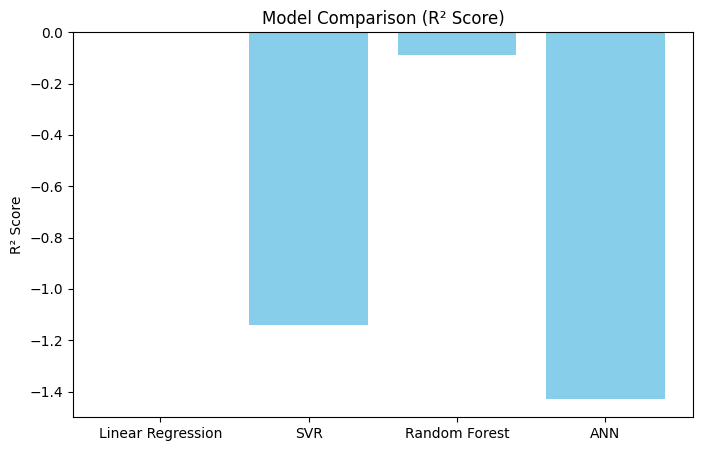

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["R2"], color='skyblue')
plt.title("Model Comparison (R² Score)")
plt.ylabel("R² Score")
plt.show()

**Predicitng for next 5 year i.e (2025 to 2030)**

In [23]:
# Generate future dates (monthly for next 5 years)
future_dates = pd.date_range(start="2025-01-01", end="2030-12-31", freq="ME")

# Create synthetic weather projections based on past stats
future_weather = pd.DataFrame({
    "temp_c": np.random.normal(df["temp_c"].mean() + 0.3, df["temp_c"].std(), len(future_dates)),
    "wind_u": np.random.normal(df["wind_u"].mean(), df["wind_u"].std(), len(future_dates)),
    "wind_v": np.random.normal(df["wind_v"].mean(), df["wind_v"].std(), len(future_dates)),
    "cloud_cover": np.random.normal(df["cloud_cover"].mean(), df["cloud_cover"].std(), len(future_dates)),
    "precipitation": np.random.normal(df["precipitation"].mean(), df["precipitation"].std(), len(future_dates)),
    "solar_radiation": np.random.normal(df["solar_radiation"].mean() + 0.1*df["solar_radiation"].mean(),
                                        df["solar_radiation"].std(), len(future_dates))
}, index=future_dates)

# Scale using the same scaler from before
future_scaled = scaler.transform(future_weather)

# Predict energy output using trained model
future_weather["predicted_energy_output"] = lr.predict(future_scaled)
future_weather["date"] = future_weather.index

# Save results
future_weather.to_csv("france_energy_forecast_2025_2030.csv", index=False)

print("✅ Future predictions saved! Shape:", future_weather.shape)
future_weather.head()

✅ Future predictions saved! Shape: (72, 8)


,temp_c,wind_u,wind_v,cloud_cover,precipitation,solar_radiation,predicted_energy_output,date
2025-01-31,18.292409,-0.900624,-2.150979,0.329828,0.000052,0.0,0.013767,2025-01-31
2025-02-28,20.036059,0.391145,-0.013482,0.340911,0.000036,0.0,0.013457,2025-02-28
2025-03-31,24.210300,-0.174480,0.271526,0.405108,0.000041,0.0,0.008394,2025-03-31
2025-04-30,13.406491,-0.179281,0.163412,0.275693,0.000007,0.0,0.031187,2025-04-30
2025-05-31,19.653275,-0.064433,-1.201749,0.300393,0.000053,0.0,0.011926,2025-05-31


**Visual Forecasting for next 5 years i.e (2025 to 2030)**

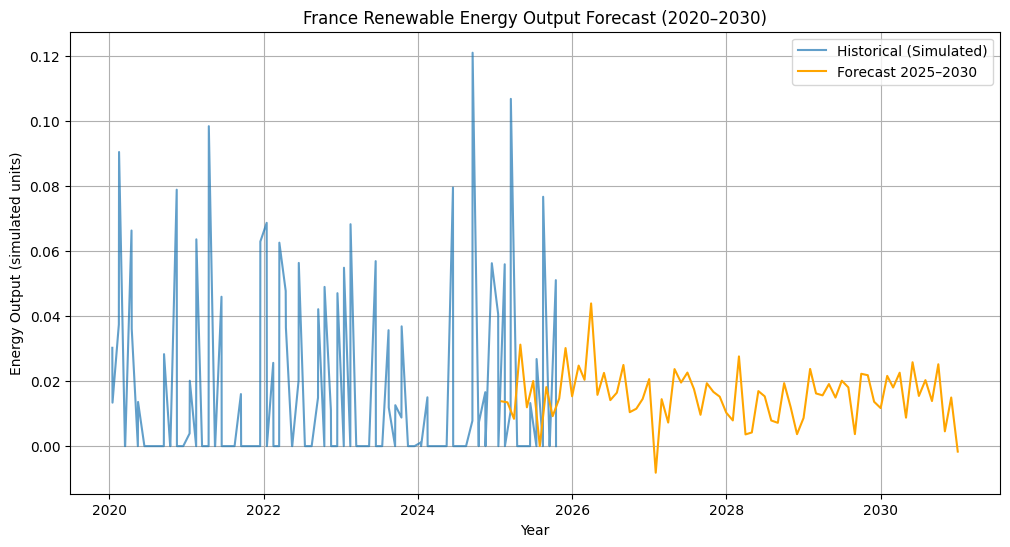

In [ ]:
import matplotlib.pyplot as plt

# Ensure date columns are in datetime format for plotting
df["time"] = pd.to_datetime(df["time"])
future_weather["date"] = pd.to_datetime(future_weather["date"])

plt.figure(figsize=(12,6))
plt.plot(df["time"], df["energy_output"], label="Historical (Simulated)", alpha=0.7)
plt.plot(future_weather["date"], future_weather["predicted_energy_output"], label="Forecast 2025–2030", color="orange")
plt.title("France Renewable Energy Output Forecast (2020–2030)")
plt.xlabel("Year")
plt.ylabel("Energy Output (simulated units)")
plt.legend()
plt.grid(True)
plt.show()